In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/20cells"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
from scipy import fftpack
from scipy.ndimage import gaussian_filter
from utils import GetSourcePts, ApproxPSFBesselModel, InverseMatrix, ApproxPSFBesselOptimise
import cv2

In [3]:
ASSUMED_NOISE_LEVEL = 1e7

/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

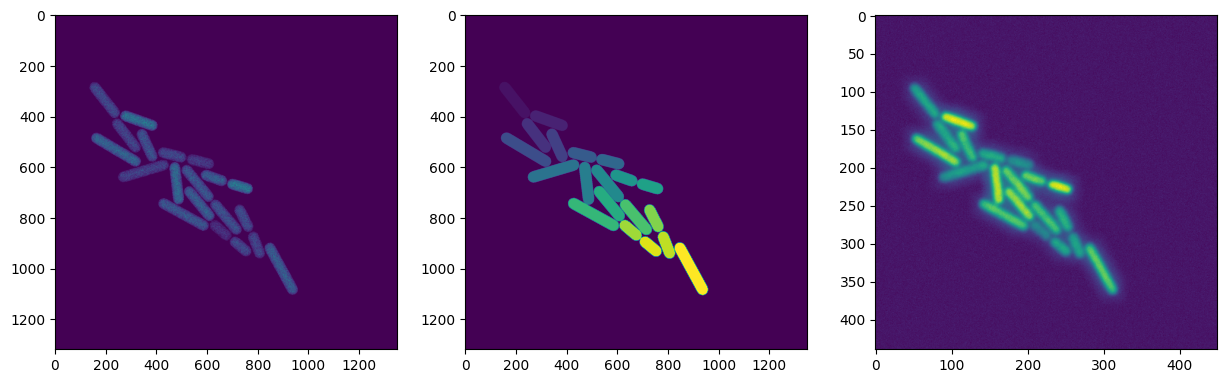

In [4]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

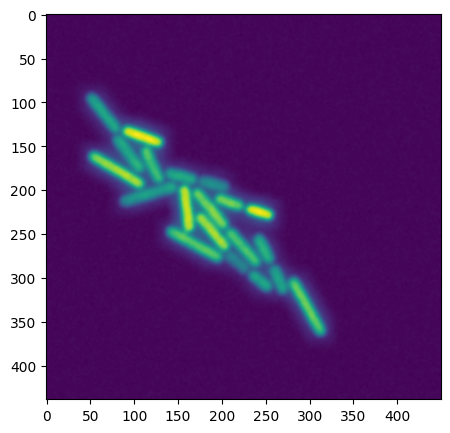

In [5]:
#Apply gaussian filter to out

outBlur = gaussian_filter(out, sigma=1)
plt.imshow(outBlur)

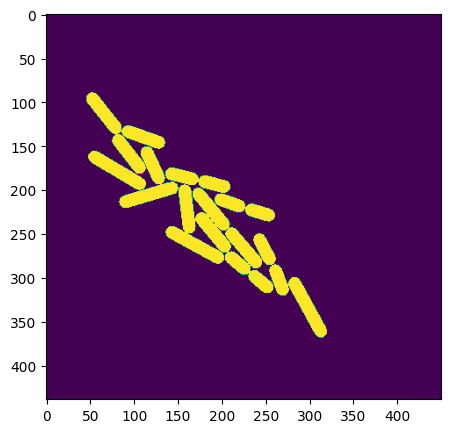

In [6]:
#Resize mask to match out
maskRescale = cv2.resize(mask, outBlur.shape[::-1], interpolation = cv2.INTER_NEAREST)

#IMPT: All mask values are set to one
maskUnit = maskRescale.copy()

for i in range(len(maskUnit)):
    for j in range(len(maskUnit[0])):
        if (maskUnit[i][j] != 0):
            maskUnit[i][j] = 1

plt.imshow(maskUnit)

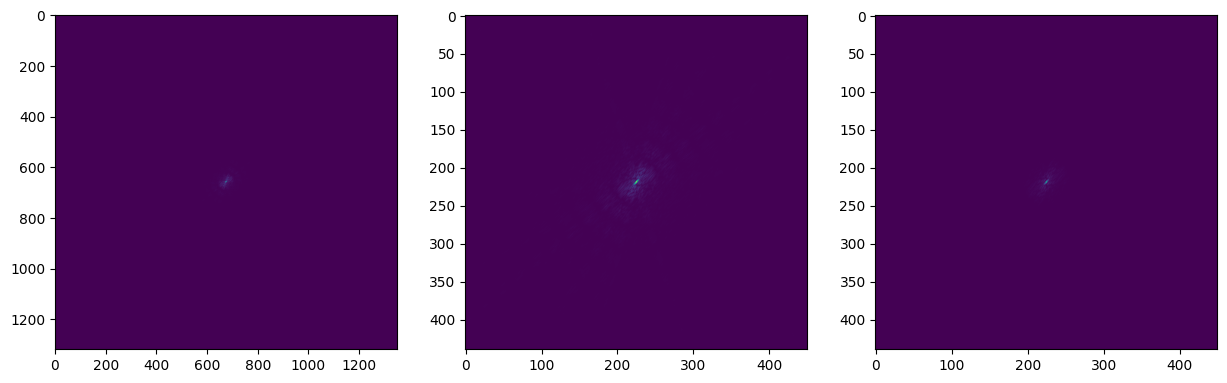

In [7]:
# Compute the 2d FFT of the input image
oriFreq = fftpack.fft2(ori)
maskFreq = fftpack.fft2(maskUnit)
outFreq = fftpack.fft2(outBlur)

# Shift the zero-frequency component to the center of the spectrum.
oriFreq = fftpack.fftshift(oriFreq)
maskFreq = fftpack.fftshift(maskFreq)
outFreq = fftpack.fftshift(outFreq)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(np.abs(oriFreq))
axarr[1].imshow(np.abs(maskFreq))
axarr[2].imshow(np.abs(outFreq))
plt.show()

In [8]:
#Transform mask.shape into odd values

psfShape = [0,0]
psfShape[0] = mask.shape[0] + 1 if mask.shape[0] % 2 == 0 else mask.shape[0]
psfShape[1] = mask.shape[1] + 1 if mask.shape[1] % 2 == 0 else mask.shape[1]


In [9]:
#Only run validation step if output shape is the same as input shape

if (out.shape == ori.shape):
    psfFreqIdeal = outFreq * np.conj(oriFreq) / (np.abs(oriFreq)**2 + ASSUMED_NOISE_LEVEL/np.max(np.abs(oriFreq)**2))
    psfIdeal = fftpack.ifft2(psfFreqIdeal,shape=psfShape)
    psfIdeal = fftpack.fftshift(psfIdeal)

    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(np.abs(psfFreqIdeal))
    axarr[1].imshow(np.abs(psfIdeal))
    plt.show()
    

    (maskWidth, maskHeight) = mask.shape
    maskSize = maskWidth*maskHeight

    #Normalise x axis of original psf to 1
    original_psf_y = psf[len(psf)//2]
    original_psf_y = original_psf_y[len(original_psf_y)//2:]
    original_psf_x = np.linspace(0,1,len(original_psf_y))*len(original_psf_y)/maskSize
    plt.plot(original_psf_x,original_psf_y)

    new_psf_y = np.abs(psfIdeal)
    new_psf_y = new_psf_y/max(new_psf_y.flatten())
    new_psf_y = new_psf_y[len(new_psf_y)//2]
    new_psf_y = new_psf_y[len(new_psf_y)//2:]
    new_psf_x = np.linspace(0,1,len(new_psf_y))*len(new_psf_y)/maskSize

    plt.plot(new_psf_x,new_psf_y)
    plt.show()

[130.67704654] [[0.02635476]]


/home/boomalope/anaconda3/envs/symbac/SyMBac/tests/dx_test_env/utils.py:291: RuntimeWarning: invalid value encountered in scalar divide
  return (2*jv(1,x*a) / (x*a))**2


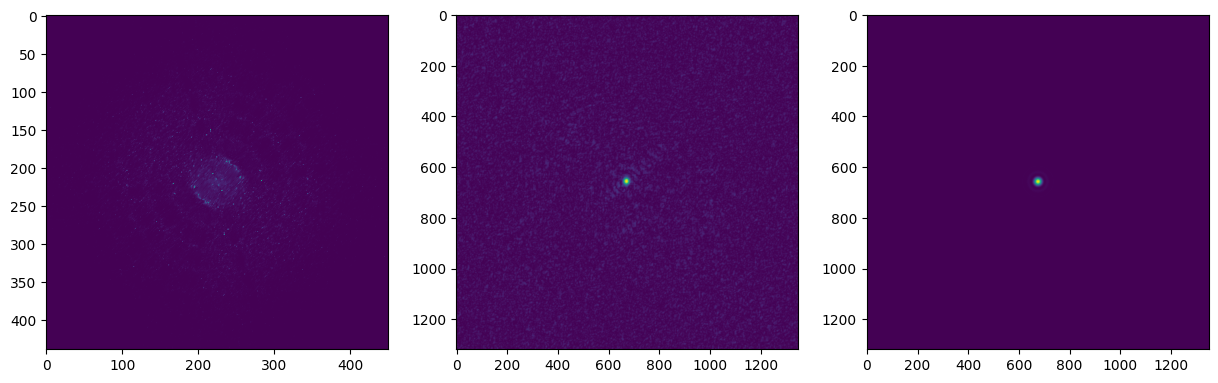

In [10]:

#We try to find psf with mask instead

psfFreqMask= outFreq * np.conj(maskFreq) / (np.abs(maskFreq)**2 + ASSUMED_NOISE_LEVEL/np.max(np.abs(maskFreq)**2))
psfMask = fftpack.ifft2(psfFreqMask, shape=psfShape)
psfMask = fftpack.fftshift(psfMask)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(np.abs(psfFreqMask))
axarr[1].imshow(np.abs(psfMask))

#Blur psf with gaussian
#psfSmooth = gaussian_filter(np.abs(psfMask), sigma=1)
psfModel = ApproxPSFBesselOptimise(np.abs(psfMask)/max(np.abs(psfMask).flatten()))

axarr[2].imshow(np.abs(psfModel))


In [11]:
#Only run validation step if output shape is the same as input shape

if (out.shape == ori.shape):
    (maskWidth, maskHeight) = mask.shape
    maskSize = maskWidth*maskHeight

    #Normalise x axis of original psf to 1
    original_psf_y = psf[len(psf)//2]
    original_psf_y = original_psf_y[len(original_psf_y)//2:]
    original_psf_x = np.linspace(0,1,len(original_psf_y))*len(original_psf_y)/maskSize
    plt.plot(original_psf_x,original_psf_y)

    new_psf_y = np.abs(psfModel)
    new_psf_y = new_psf_y/max(new_psf_y.flatten())
    new_psf_y = new_psf_y[len(new_psf_y)//2]
    new_psf_y = new_psf_y[len(new_psf_y)//2:]
    new_psf_x = np.linspace(0,1,len(new_psf_y))*len(new_psf_y)/maskSize
    plt.plot(new_psf_x,new_psf_y)
    plt.show()

In [12]:
sourcePts = GetSourcePts(mask)
sourcePtsRescale = GetSourcePts(maskRescale)
recoveredImage = InverseMatrix(out, maskRescale, sourcePtsRescale, adjPts=5, learningRate = 1, psf=psfModel)

[0.04761905, 0.0952381, 0.14285715, 0.1904762, 0.23809524, 0.2857143, 0.33333334, 0.3809524, 0.42857143, 0.47619048, 0.52380955, 0.5714286, 0.61904764, 0.6666667, 0.71428573, 0.8095238, 0.85714287, 0.9047619, 0.95238096, 1.0]
[[0.59648575]
 [0.91315482]
 [0.34708971]
 [0.509378  ]
 [0.80165321]
 [0.47439989]
 [0.37339035]
 [0.41032972]
 [0.76064361]
 [0.52492887]
 [0.64576057]
 [1.        ]
 [0.60425682]
 [0.62327472]
 [0.54400923]
 [0.52004596]
 [0.23921778]
 [0.42569801]
 [0.5289077 ]
 [0.77729684]]


/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

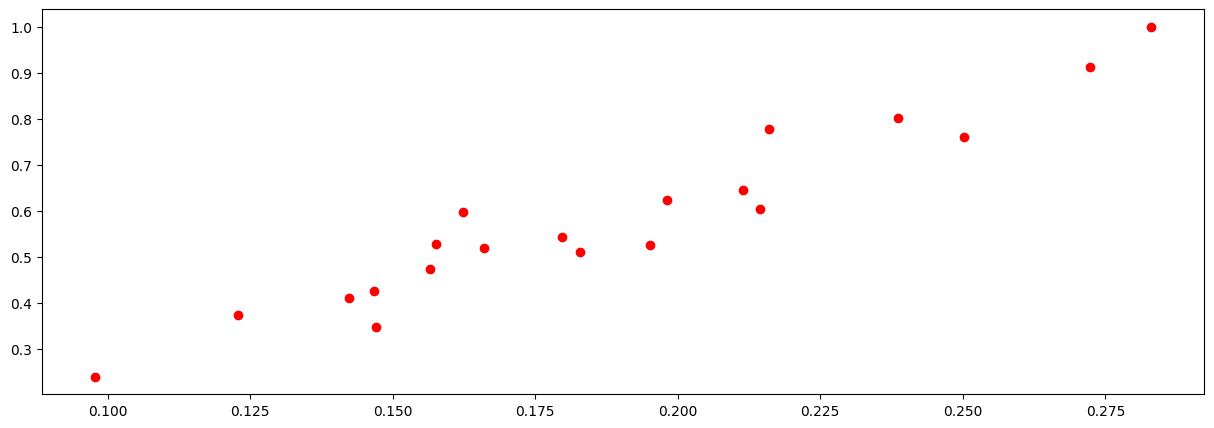

array([[1.        , 0.95896749],
       [0.95896749, 1.        ]])

In [13]:
#Get average intensity in each mask

average_original_intensity = {}
for x in sourcePts:
    if not mask[x[0],x[1]] in average_original_intensity:
        average_original_intensity[mask[x[0],x[1]]] = [ori[x[0],x[1]],1]
    else:
        average_original_intensity[mask[x[0],x[1]]][0] += ori[x[0],x[1]]
        average_original_intensity[mask[x[0],x[1]]][1] += 1

average_output_intensity = {}
for x in sourcePts:
    if not maskRescale[x[0],x[1]] in average_output_intensity:
        average_output_intensity[maskRescale[x[0],x[1]]] = [out[x[0],x[1]],1]
    else:
        average_output_intensity[maskRescale[x[0],x[1]]][0] += out[x[0],x[1]]
        average_output_intensity[maskRescale[x[0],x[1]]][1] += 1

average_custom_intensity = {}
for x in sourcePtsRescale:
    if not maskRescale[x[0],x[1]] in average_custom_intensity:
        average_custom_intensity[maskRescale[x[0],x[1]]] = [recoveredImage[x[0],x[1]],1]
    else:
        average_custom_intensity[maskRescale[x[0],x[1]]][0] += recoveredImage[x[0],x[1]]
        average_custom_intensity[maskRescale[x[0],x[1]]][1] += 1


average_original_intensity = [ v[0]/v[1] for k, v in average_original_intensity.items() ]
average_original_intensity = np.array(average_original_intensity)
average_inteaverage_original_intensitynsity = average_original_intensity/max(average_original_intensity)

average_custom_intensity = [ v[0]/v[1] for k, v in average_custom_intensity.items() ]
average_custom_intensity = np.array(average_custom_intensity)
average_custom_intensity = average_custom_intensity/max(average_custom_intensity)

plt.plot(average_original_intensity,average_custom_intensity,'ro')
plt.show()

#Calculate correlation coefficient
np.corrcoef(average_original_intensity,average_custom_intensity)

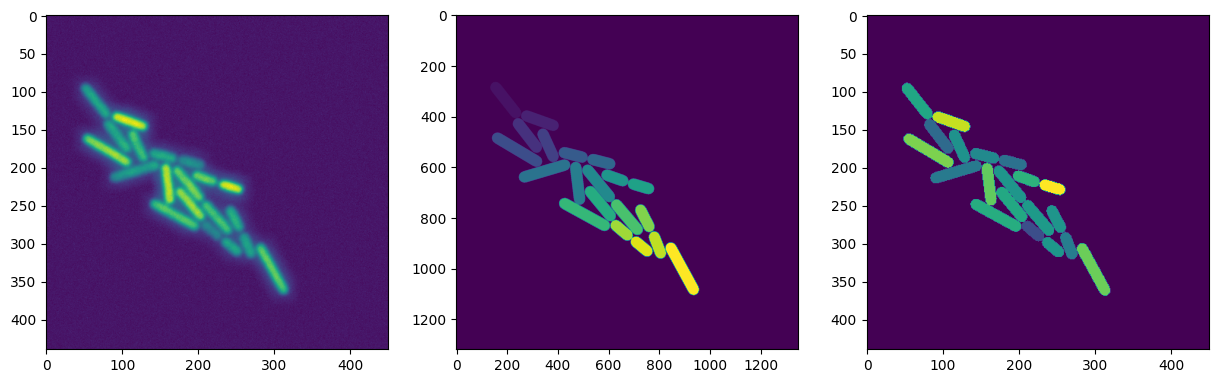

In [14]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(out)
axarr[1].imshow(mask)
axarr[2].imshow(recoveredImage)